# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


## Librerías de uso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Preprocesamiento de los datos
Para el preprocesamiento de los datos fue necesario añadir varias excepciones para la lectura de datos, ya que el formato de 
estos no era consistente en su totalidad

In [2]:
file_path = './datos/precios/Precio_Bolsa_Nacional_($kwh)_'

complete_df = None
for year in range(1995,2019):
    extension = 'xlsx'
    if (year >= 2016):
        extension = 'xls'
    filestring = file_path + str(year) +'.'+ extension
    skiprows=3
    if (year >= 2000):
        skiprows = 2
    df = pd.read_excel(filestring,skiprows=skiprows)
    means = []
    df = df.dropna(axis='index', thresh=10)
    df = df.dropna(axis='columns', how='all')
    for index, row in df.iterrows():
        s = 0
        c = 0
        for i in range(0,24):
            value = row[str(i)]
            if (not pd.isnull(value)):
                s += float(value)
                c += 1
        prom = s/c
        means.append(prom)
    df['Mean'] = means
    if (year == 1995):
        complete_df = df
    else:
        complete_df = complete_df.append(df)
parsed_dates = []
for d in complete_df['Fecha'].values:
    if (isinstance(d,str)):
        parsed_dates.append(dt.datetime.strptime(d,"%Y-%m-%d"))
    elif (isinstance(d,dt.datetime)):
        parsed_dates.append(d)
    else:
        print(d)
        print(type(d))
complete_df['Parse Date'] = pd.to_datetime(parsed_dates)

complete_df['Timestamp'] = [d.timestamp() for d in parsed_dates]
complete_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,Mean,NaN,Unnamed: 26,Timestamp
count,8396.000000,8396.000000,8399.000000,8397.000000,8400.000000,8400.000000,8395.000000,8400.000000,8398.000000,8400.000000,...,8400.000000,8400.000000,8400.000000,8399.000000,8400.000000,8399.000000,8400.000000,365.000000,1096.000000,8.400000e+03
mean,94.894760,92.225018,90.481800,89.820847,91.875322,97.393668,98.849377,102.907985,107.703317,110.057409,...,124.882346,132.515216,121.136281,113.722311,105.951791,99.023616,107.256202,75.013184,172.728791,1.164668e+09
std,123.549943,118.820196,117.353192,113.791278,114.577197,121.587657,121.585878,126.268919,131.341183,132.971299,...,139.447157,140.298005,137.610502,135.153642,131.446948,125.436527,128.372835,21.329104,86.094551,2.077268e+08
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499792,35.356674,38.397980,8.062164e+08
25%,37.347355,36.879062,36.364631,36.246583,37.321099,39.553350,39.958856,42.157859,45.211945,46.169674,...,56.737062,62.877671,55.580568,49.984394,43.917158,39.039229,46.001686,59.497735,132.496797,9.839196e+08
50%,65.866872,64.739182,64.123530,63.978184,65.210519,67.996943,69.255438,71.540069,74.644855,76.273409,...,90.169674,96.074484,85.976229,79.255884,72.459721,67.868907,74.653875,72.466983,162.804898,1.165338e+09
75%,116.394779,113.634484,111.184232,110.831014,113.713497,120.283444,122.090915,125.807304,130.596225,133.405265,...,153.683890,166.491698,148.158058,136.762786,129.378072,123.197570,132.123855,89.774928,191.236969,1.344078e+09
max,1942.776133,1942.776133,1942.776133,1940.837460,1942.776133,1942.776133,1942.776133,1955.820551,2821.520551,1942.776133,...,1955.820551,1955.820551,1942.820551,1946.437460,1955.820551,1944.516236,1942.692800,130.143544,478.874958,1.525496e+09


### Vista previa de los datos originales

In [3]:
complete_df.head()


,Fecha,0,1,2,3,4,5,6,7,8,...,20,21,22,23,Mean,Version,NaN,Unnamed: 26,Parse Date,Timestamp
0,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,...,1.897,1.897,1.073,1.073,1.409435,NaN,NaN,NaN,1995-07-20,806216400.0
1,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,...,11.929,5.000,1.000,1.000,4.924333,NaN,NaN,NaN,1995-07-21,806302800.0
2,1995-07-22,1.073,1.073,1.000,1.000,1.000,1.073,1.303,1.303,1.303,...,2.500,1.303,1.073,1.073,1.269500,NaN,NaN,NaN,1995-07-22,806389200.0
3,1995-07-23,1.073,1.000,1.000,1.000,1.000,1.000,0.100,1.000,1.000,...,1.238,1.238,1.073,1.000,0.953083,NaN,NaN,NaN,1995-07-23,806475600.0
4,1995-07-24,1.000,1.000,0.990,1.000,1.000,1.073,3.000,3.000,3.000,...,9.256,3.000,1.073,1.000,4.305917,NaN,NaN,NaN,1995-07-24,806562000.0


## Gráfica de la tendencia promedio de los precios

Se realiza una gráfica para observar el comportamiento de los precios a lo largo de los años, se identifica el gran pico en la crisis energética de 2016

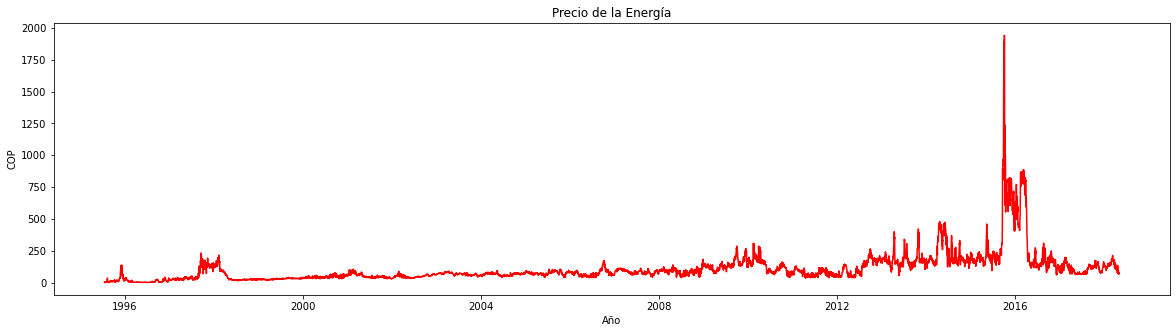

In [4]:
complete_df.sort_values(by='Parse Date')
complete_df.drop_duplicates(subset="Parse Date", keep="first", inplace=True)
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('COP')
plt.plot(complete_df['Parse Date'], complete_df['Mean'], color='red')
plt.show()

## IPC 
Es necesario normalizar los datos multiplicandolos por el IPC histórico y así poder descartar la inflación como variable de cambio, para esto se hará uso del archivo de excel 'ipc_historico.xlsx, que también se encuentra en la carpeta de datos, este archivo se obtuvo de la página web del <a href="https://www.banrep.gov.co/es/estadisticas/indice-precios-consumidor-ipc" target="_blank">Banco de la República</a>  

In [5]:
ipc_df = pd.read_excel('./datos/precios/series_ipc_historico.xlsx', skiprows=12, parse_dates=True)
ipc_df = ipc_df.dropna(axis='index', thresh=2)
ipc_df = ipc_df.dropna(axis='columns', how='all')
ipc_df['Parse Date'] = [dt.datetime.strptime(str(d),"%Y%m") for d in ipc_df['Año(aaaa)-Mes(mm)'].tolist()]
ipc_df.sort_values(by='Parse Date', inplace=True)
ipc_df.tail()



,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido,Parse Date
4,201910,103.43,0.0386,0.0016,0.0343,2019-10-01
3,201911,103.54,0.0384,0.0010,0.0354,2019-11-01
2,201912,103.80,0.0380,0.0026,0.0380,2019-12-01
1,202001,104.24,0.0362,0.0042,0.0042,2020-01-01
0,202002,104.94,0.0372,0.0067,0.0109,2020-02-01


In [6]:
#Obtenemos el IPC base
mask = (ipc_df['Índice'] == 100)
base_ipc_df = ipc_df.loc[mask]
base_ipc_df.head()

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido,Parse Date
14,201812,100.0,0.0318,0.003,0.0318,2018-12-01


In [7]:
base_ipc = base_ipc_df['Índice'].tolist()[0]
print(base_ipc)

100.0


In [8]:
normalized_means = []
for m,d in zip(complete_df['Mean'].tolist(), complete_df['Timestamp'].tolist()):
    date = dt.datetime.utcfromtimestamp(d)
    mask = (ipc_df['Parse Date'].dt.year == date.year) & (ipc_df['Parse Date'].dt.month == date.month)
    ipc = ipc_df.loc[mask]['Índice'].values[0]
    normalized_price = m * (base_ipc/ipc)
    normalized_means.append(normalized_price)

complete_df['Precio Normalizado'] = normalized_means    

complete_df.tail()

,Fecha,0,1,2,3,4,5,6,7,8,...,21,22,23,Mean,Version,NaN,Unnamed: 26,Parse Date,Timestamp,Precio Normalizado
120,2018-05-01,64.229226,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,...,81.229226,71.229226,64.229226,71.666726,TX2,NaN,NaN,2018-05-01,1.525151e+09,72.273826
121,2018-05-02,63.332816,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,...,80.832816,80.832816,67.832816,76.374441,TX2,NaN,NaN,2018-05-02,1.525237e+09,77.021421
122,2018-05-03,63.710848,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,...,67.710848,67.710848,63.710848,71.148348,TX1,NaN,NaN,2018-05-03,1.525324e+09,71.751057
123,2018-05-04,61.543453,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,...,65.543453,65.543453,64.043453,64.710120,TX1,NaN,NaN,2018-05-04,1.525410e+09,65.258289
124,2018-05-05,73.742918,73.742918,70.242918,70.242918,70.242918,70.242918,73.742918,73.742918,75.242918,...,75.242918,75.242918,75.242918,73.972085,TX1,NaN,NaN,2018-05-05,1.525496e+09,74.598714


## Comparación de Precio vs Precio Normalizado

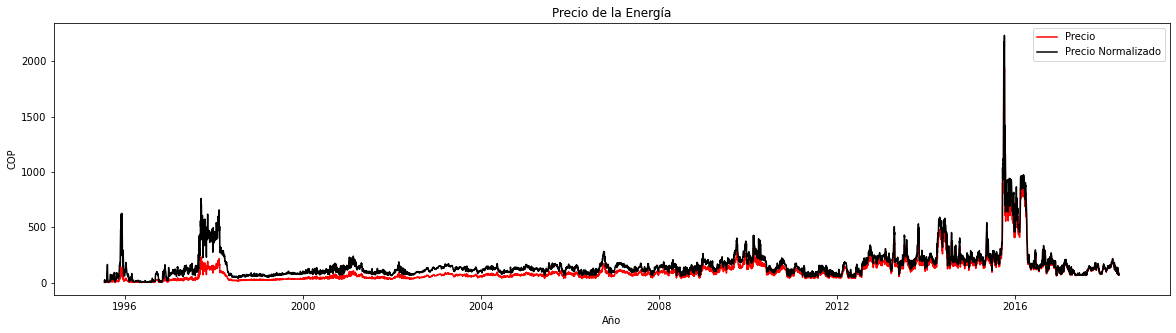

In [9]:
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('COP')
plt.plot(complete_df['Parse Date'], complete_df['Mean'], label="Precio", color='red')
plt.plot(complete_df['Parse Date'], complete_df['Precio Normalizado'], label="Precio Normalizado", color='black')
plt.legend()
plt.show()

# Transformación de los Datos
Finalizado el proceso de preprocesamiento, se conformará un nuevo dataframe con los datos estrictamente necesarios, y una a una se irán agregando las transformaciones a los precios normalizados. Las transformaciones a usar serán:
<ul>
    <li>Logaritmo natural</li>
    <li>Raíz cuadrada</li>
    <li>Raíz cúbica</li>
</ul>

In [10]:
def transform(values,trans, inverse = False):
    if (not inverse):
        if (trans == "Log_Natural"):
            return np.log(values)
        elif (trans == "Raiz_Cuadrada"):
            return np.sqrt(values)
        elif (trans == "Raiz_Cubica"):
            return np.cbrt(values)
        else:
            return values
    else:
        if (trans == "Log_Natural"):
            return np.exp(values)
        elif (trans == "Raiz_Cuadrada"):
            return np.power(values,2)
        elif (trans == "Raiz_Cubica"):
            return np.power(values,4)
        else:
            return values

##Nuevo dataframe solo con los datos requeridos
df_dict = {
    "Fecha": complete_df['Parse Date'],
    "Timestamp": complete_df['Timestamp'],
    "Precio_Promedio": complete_df['Mean'],
    "Precio_Normalizado": complete_df['Precio Normalizado']
}
df = pd.DataFrame(df_dict)
transformations = ['Log_Natural', 'Raiz_Cuadrada', 'Raiz_Cubica']
for t in transformations:
    ##Le agregamos las distintas transformaciones al precio normalizado
    df[t] = transform(df['Precio_Normalizado'],t)
df['Precio_Normalizado_SCL'] = df['Precio_Normalizado']
df.describe()

,Timestamp,Precio_Promedio,Precio_Normalizado,Log_Natural,Raiz_Cuadrada,Raiz_Cubica,Precio_Normalizado_SCL
count,8.326000e+03,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000,8326.000000
mean,1.165854e+09,107.497293,159.682949,4.818459,11.856760,5.128808,159.682949
std,2.076787e+08,128.747068,148.263375,0.740336,4.370639,1.219586,148.263375
min,8.062164e+08,0.499792,2.387920,0.870423,1.545290,1.336616,2.387920
25%,9.860364e+08,46.297403,89.982346,4.499613,9.485902,4.481112,89.982346
50%,1.165856e+09,74.706517,125.280368,4.830554,11.192871,5.003735,125.280368
75%,1.345676e+09,132.281824,176.898179,5.175574,13.300307,5.613596,176.898179
max,1.525496e+09,1942.692800,2233.493676,7.711322,47.259853,13.071585,2233.493676


## Gráfica comparativa de cada una de las transformaciones

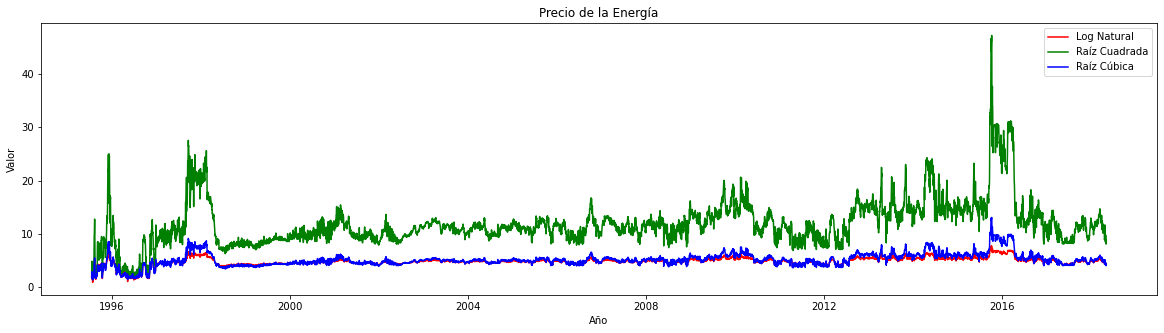

In [11]:
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Valor')
#plt.plot(df['Fecha'], df['Precio_Normalizado'], label="Precio Normalizado", color='black')
plt.plot(df['Fecha'], df['Log_Natural'], label="Log Natural", color='red')
plt.plot(df['Fecha'], df['Raiz_Cuadrada'], label="Raíz Cuadrada", color='green')
plt.plot(df['Fecha'], df['Raiz_Cubica'], label="Raíz Cúbica", color='blue')

plt.legend()
plt.show()

## Elección de la Transformación

Para elegir la transformación adecuada se realizará el modelo, se hará un pronóstico y se seleccionará aquella transformación con menor error


### Implementación del Modelo

La implementación del modelo escogida es la propuesta por el profesor en el siguiente <a href="https://jdvelasq.github.io/courses/notebooks/tensorflow/adaline/1-01-adalines.html" target="_blank">enlace</a>

In [12]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 momentum=0,      # Momentum               
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #
        
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n) #Desordena una lista de indices
                X = X[n,:] 
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_ 
                e = (d[i] - u)[0]
                ## Se agrega el momentum al coeficiente e intercepto
                self.coef_ += 2 * self.learning_rate * e * X[i,:] + self.coef_ * self.momentum
                self.intercept_ += 2 * self.learning_rate * e + self.intercept_*self.momentum
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

In [13]:
transformations = ['Log_Natural', 'Raiz_Cuadrada', 'Raiz_Cubica','Precio_Normalizado_SCL']
L = 7
scalers = dict() ## Scalers para cada transformación
desireds_d = dict() ## Deseados 
forecasts_d = dict() ## Pronóstico
errors2_d = dict() ## errores

## Realizar el pronóstico para cada transformación
for trans in transformations:
    scaler = MinMaxScaler() ##Scaler
    d = np.asarray(df[trans]).reshape(-1,1)
    scaler.fit(d)
    scaled_d = scaler.transform(d).ravel() ##Usar los valores escalados entre 0 y 1 
    scalers[trans] = scaler
    desireds_d[trans] = d
    X = []
    for t in range(L, len(d)):
        X.append(scaled_d[t-L:t].copy())
        
    adaline = Adaline(
    learning_rate=0.001, 
    max_epochs=1,        
    shuffle=False,       
    random_state=123,    
    warm_start=False)    
    
    errors2, forecasts = adaline.fit(X,scaled_d[L:])
    forecasts_d[trans] = scaler.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel() ##Regresar a la escala
    errors2_d[trans] = errors2



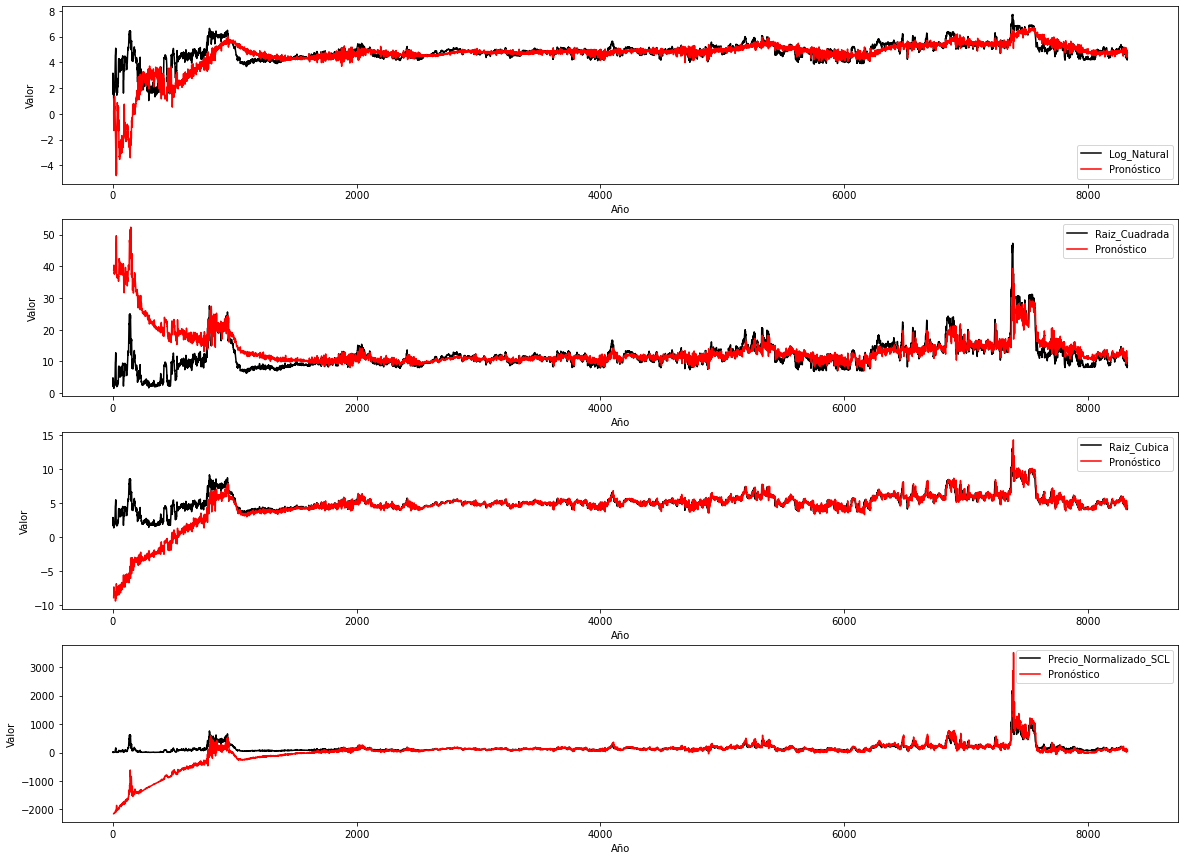

In [14]:
plt.figure(figsize=(20,15)) 
for i in range(len(transformations)):
    trans = transformations[i]
    plt.subplot(4,1,i+1)   
    plt.xlabel('Año')
    plt.ylabel('Valor')
    plt.plot(desireds_d[trans], label=trans, color='black')
    plt.plot(range(L, len(desireds_d[trans])),forecasts_d[trans], label="Pronóstico", color='red')
    plt.legend()


Se observa que todas las transformaciones tienen un comportamiento similar, un poco errático por la alta variación de los datos. Entre estas la que más destaca es la transformación de Log_Natural, de igual manera se realizará el análisis modificando las tasa de aprendizaje y otros valores.

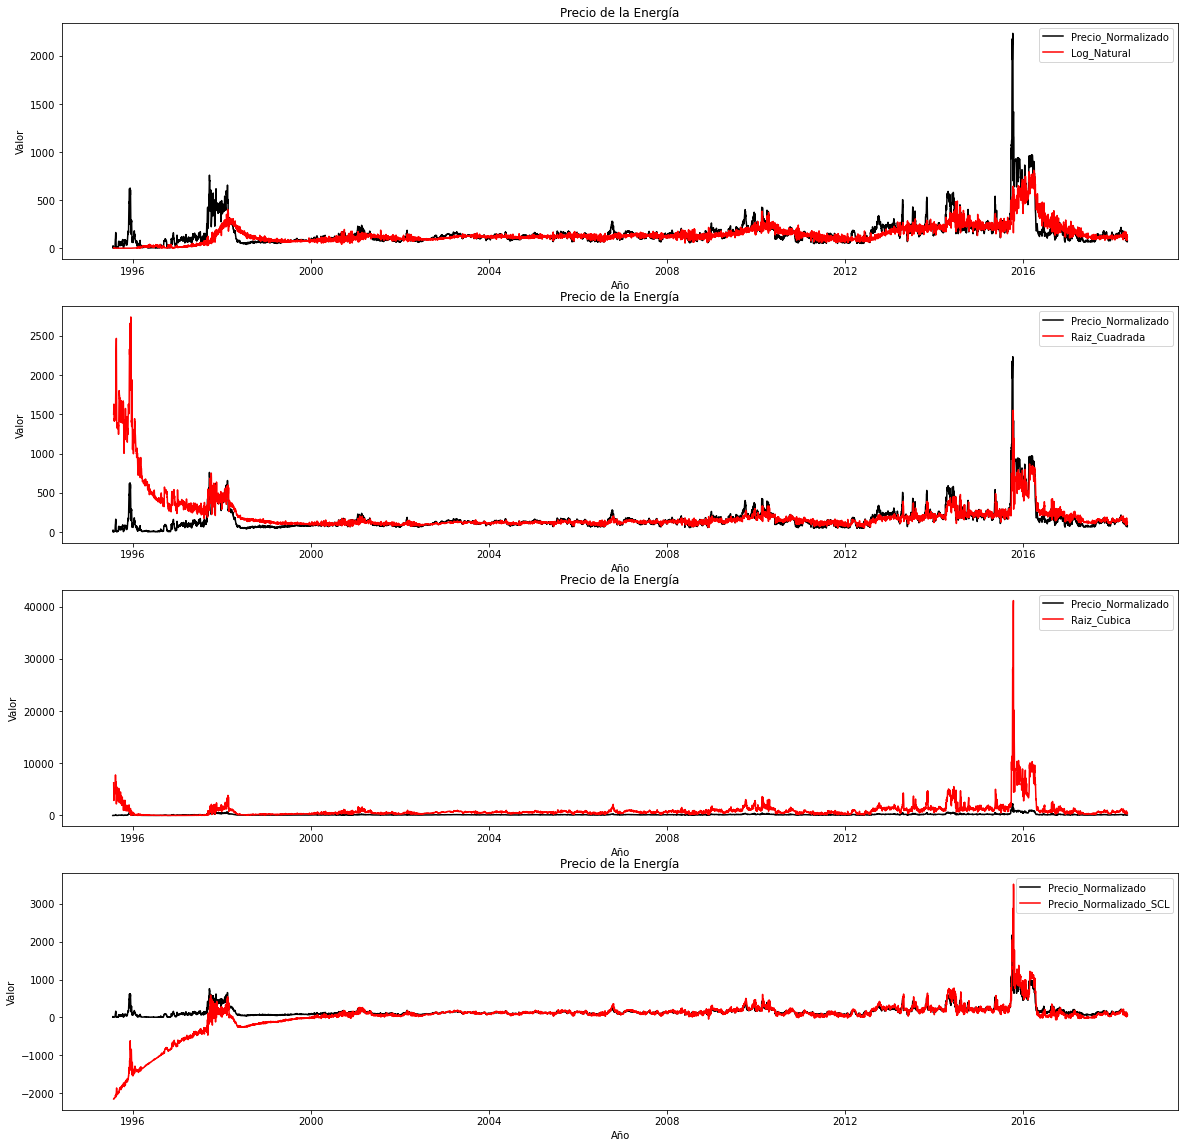

In [15]:
## Aplicando la transformación inversa
forecast_inv = dict()
for t in transformations:
    forecast_inv[t] = transform(forecasts_d[t],t,True)

plt.figure(figsize=(20,20))
first_date = dt.datetime.utcfromtimestamp(df['Timestamp'].tolist()[0])
date_thresh = (df['Fecha'] >= first_date + dt.timedelta(L-1))
dates_df = df.loc[date_thresh]['Fecha']
for i in range(len(transformations)):
    trans = transformations[i]
    plt.subplot(len(transformations),1,i+1)   
    plt.title('Precio de la Energía')
    plt.xlabel('Año')
    plt.ylabel('Valor')
    plt.plot(df['Fecha'],df['Precio_Normalizado'], label='Precio_Normalizado', color='black')
    plt.plot(dates_df,forecast_inv[trans], label=trans, color='red')
    plt.legend()

plt.legend()
plt.show()

Realizando la comparación se puede notar que las transformaciones tienen un comportamiento bastante errático, manteniéndose la más estable la transformación de Logaritmo Natural, de igual manera se evaluarán todas las transformaciones para realizar la elección del modelo.

## Separación de Datos (Predicción y Entrenamiento)

In [16]:
models = transformations
n = df['Precio_Normalizado'].size 
train_df = pd.DataFrame(columns=models) ##Dataframe de entrenamiento
predict = df.iloc[(n - 7):]['Precio_Normalizado'] ##Datos a predecir
for model in models: 
    train_df[model] = df[model][:(n-7)]

Se guardan los resultados de los errores del modelo en un dataframe

In [17]:
Ls= list(range(7, 11)) #Latencia
result_df = pd.DataFrame(columns = ["Modelo","E_Pronostico","E_Entrenamiento","L","Momentum","Tasa_Apr","Pronosticos"])

for model in models:
    d = np.asarray(train_df[model]).reshape(-1,1)
    scaler = scalers[model]
    d = scaler.transform(d).ravel() #Datos para usar en el modelo
    for L in Ls:
        for momentum in np.arange(0.00000, 0.0001,0.000025): #Se eligieron valores muy bajos del momentum porque variaba demasiado
            for learning_rate in np.arange(0.005, 0.1, 0.005):
                X = []
                P = []
                for t in range(L,len(d)):
                    X.append(d[t-L:t].copy())

                #Se entrena el modelo
                adaline = Adaline(
                    learning_rate=learning_rate, 
                    momentum = momentum,  
                    shuffle=False,       
                    random_state=123,
                    max_epochs=1,
                    warm_start=False)    
                errors2, forecasts = adaline.fit(X, d[L:])

                #Generar pronósticos
                for i in range(7):
                    u = adaline.predict(X[-1])
                    next_X = np.append(X[-1][1:L], [u])
                    X = np.concatenate( ( X, [next_X] ), axis=0) 
                    P.append(u[0])

                #Invertir la transformación de escalado    
                P = scaler.inverse_transform(np.asarray(P).reshape(-1,1)).ravel() 
                forecasts = scaler.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel() 
                
                #Invertir la transformación aplicada
                if (model != 'Precio_Normalizado'):
                    P = transform(P,model,True)  
                    forecasts = transform(forecasts,model,True)

                e_p = np.sum(np.power(np.array(predict) - P, 2)) #Error cuadrático total del pronóstico
                e = np.sum(errors2) #Error total de entrenamiento
                #Guardar valores del pronóstico
                result_df = result_df.append({
                    "Modelo": model,
                    "E_Pronostico": e_p,
                    "E_Entrenamiento": e,
                    "L": L,
                    "Momentum": momentum,
                    "Tasa_Apr": learning_rate,
                    "Pronosticos_E":forecasts,
                    "Pronosticos": P,
                },ignore_index=True)
                
result_df.describe()

,E_Pronostico,E_Entrenamiento,Momentum,Tasa_Apr
count,1.216000e+03,1216.000000,1216.000000,1216.000000
mean,7.813372e+20,18.602974,0.000038,0.050000
std,2.724616e+22,14.419682,0.000028,0.027397
min,6.886318e+02,2.606379,0.000000,0.005000
25%,1.304164e+04,10.624848,0.000019,0.025000
50%,3.512247e+04,14.819761,0.000038,0.050000
75%,8.889703e+05,21.157375,0.000056,0.075000
max,9.501060e+23,161.961409,0.000075,0.095000


In [18]:
best_predict = result_df[result_df.E_Pronostico == result_df.E_Pronostico.min()] ##Mejor pronóstico
best_train = result_df[result_df.E_Entrenamiento == result_df.E_Entrenamiento.min()] ##Mejor entrenamiento

best_predict.head() 

,Modelo,E_Pronostico,E_Entrenamiento,L,Momentum,Tasa_Apr,Pronosticos,Pronosticos_E
102,Log_Natural,688.631835,15.124831,8,0.000025,0.04,"[83.9535238888037, 80.01845490784464, 79.73203...","[143.22983769909987, 3.356499629784748, 14.619..."


In [19]:
best_train.head()

,Modelo,E_Pronostico,E_Entrenamiento,L,Momentum,Tasa_Apr,Pronosticos,Pronosticos_E
1003,Precio_Normalizado_SCL,13982.103573,2.606379,8,0.0,0.08,"[113.8442205065645, 143.33946833807252, 145.43...","[-46.40428386976777, -42.80212706171189, -16.6..."


## Modelo seleccionado
Finalmente se selecciona el modelo con un menor error de entrenamiento para realizar la predicción de los próximos 7 días. De igual forma se grafica el modelo con el mejor pronóstico para contemplar el comportamiento del pronóstico realizado vs el real, donde se puede observar un comportamiento casi similar en cuestión de subida y caída del precio. En este caso el Modelo seleccionado es el Modelo de Precio Normalizado, con un retardo de 8 días, Momentum 0 y Tasa de Aprendizaje de 0.08

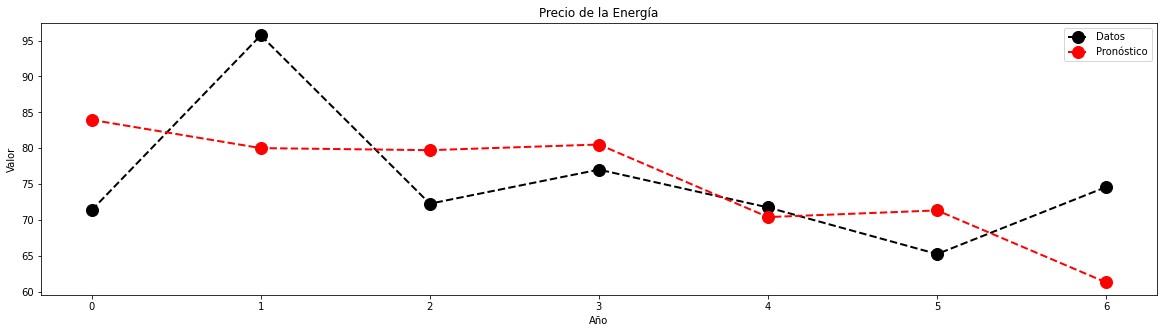

In [20]:
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.plot(predict.values, label="Datos", color='black', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(best_predict['Pronosticos'].values[0],label="Pronóstico", color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

plt.legend()
plt.show()

### Comportamiento general del Modelo

Se gráfica el comportamiento general del modelo seleccionado


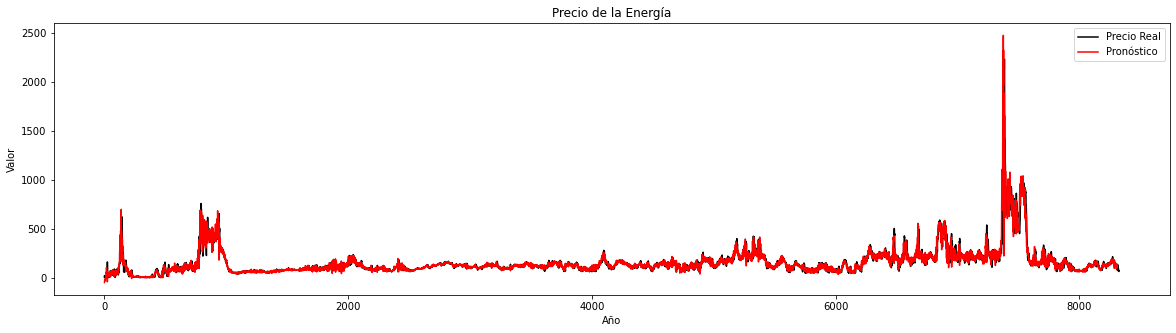

In [21]:
#forecasts_p = best_predict['Pronosticos_E'].values[0]
forecasts_t = best_train['Pronosticos_E'].values[0]

plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.plot(df['Precio_Normalizado'].values, label="Precio Real", color = "black")
plt.plot(forecasts_t, label="Pronóstico", color="red")

plt.legend()
plt.show()

## Pronóstico de los 7 días con el modelo escogido

In [22]:
##Se obtienen los datos del mejor pronóstico
transformation = best_train['Modelo'].values[0]
learning_rate = best_train['Tasa_Apr'].values[0]
momentum =  best_train['Momentum'].values[0]
L = best_train['L'].values[0]

d = np.asarray(df[transformation]).reshape(-1,1)
scaler = scalers[transformation]
d = scaler.transform(d).ravel() ##Datos para usar en el modelo

X = []
P = []
for t in range(L,len(d)):
    X.append(d[t-L:t].copy())

adaline = Adaline(
    learning_rate=learning_rate,  
    momentum = momentum, 
    max_epochs=1,        
    shuffle=False,       
    random_state=123,    
    warm_start=False)    
errors2, forecasts = adaline.fit(X, d[L:]) 

##Pronósticar los próximos 7 días
for i in range(7):
    u = adaline.predict(X[-1]) 
    next_X = np.append(X[-1][1:L], [u]) 
    X = np.concatenate( ( X, [next_X] ), axis=0)
    forecasts.append(u[0]) 
    P.append(u[0])
    
forecasts = scaler.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel()
forecasts = transform(forecasts,model,True)
P = scaler.inverse_transform(np.asarray(P).reshape(-1,1)).ravel()
P = transform(P,model,True)

    


### Comportamiento del Precio de la Energía para los próximos 7 días

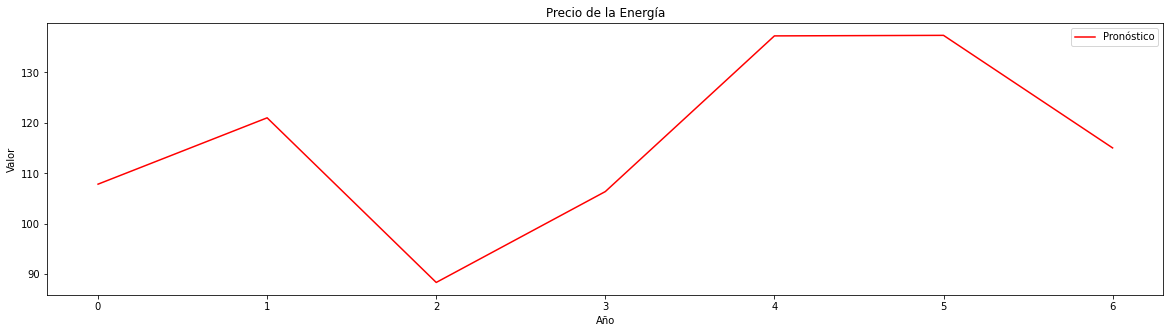

In [23]:
plt.figure(figsize=(20,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.plot(P, label="Pronóstico", color="red")

plt.legend()
plt.show()

In [24]:
print(P)

[107.84755961 121.00099351  88.3571973  106.37831365 137.24938746
 137.35583455 115.03567602]
